Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

#the autoreload
%load_ext autoreload
%autoreload 2

# set random seed
np.random.seed(0)

Data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")

# Select portion of data 

In [3]:
labels_raw_portion = labels_raw[:10000]
data_raw_portion = data_raw[:10000,:]
ids_raw_portion = ids_raw[:10000]

Data filtering and standardization
===

In [4]:
data_, labels, ids, idx_colrem = process_data(data_raw_portion, labels_raw_portion, ids_raw_portion)
data, means, variance = standardize(data_)

The original dimensions of the training data set was 10000 samples and 30 columns. After feature and sample filtering, there are 8976 samples and 23 columns


Splitting into train and test set
===

In [6]:
X_train, y_train, X_test, y_test = split_data(data, labels)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


In [7]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)

(8976, 23)
(7180, 23)
(1796, 23)


Linear regression with gradient descent (GD)
===

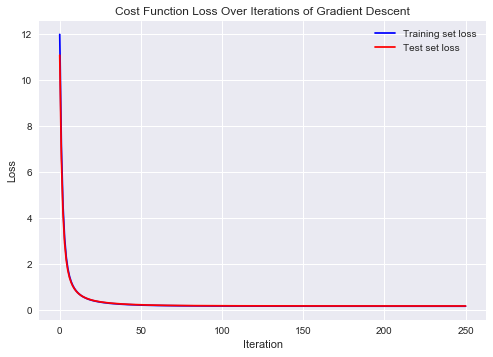

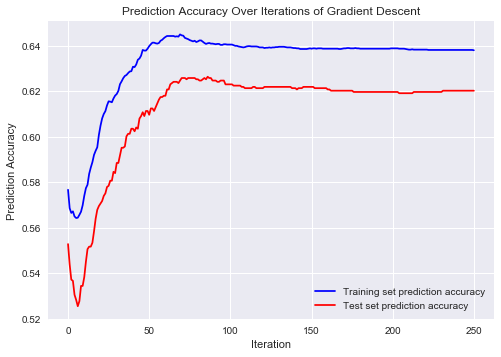

In [8]:
# initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_GD(y_train, X_train, initial_w, max_iters = 250) # fit model and retrieve W's across iterations
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()


Linear regression with stochastic gradient descent (SGD)
===

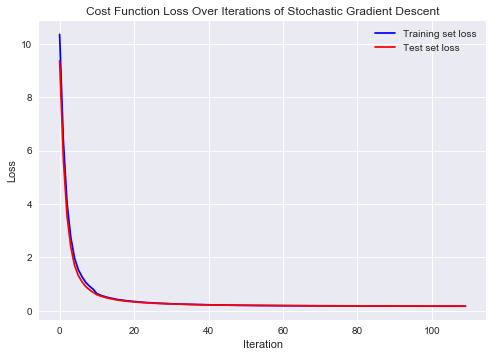

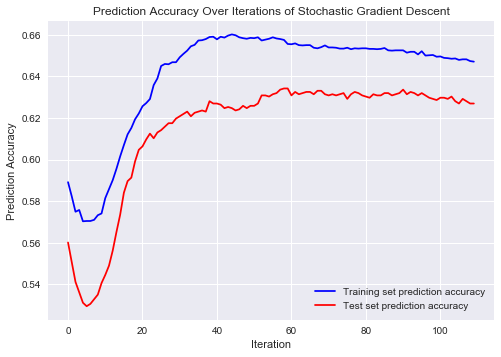

In [9]:
#initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

In [10]:
w = least_squares(y_train, X_train)

pred_y = predict_labels(w, X_test)
pred_accuracy(pred_y,y_test)

0.6191536748329621

Linear regression using the normal equations with additional polynomial degrees
===

degree: 1 	 rmse_ts: 0.44491225310058846 	  pred_ts: 0.6770601336302895
degree: 2 	 rmse_ts: 0.42435897412325757 	  pred_ts: 0.7271714922048997
degree: 3 	 rmse_ts: 0.42918153055209957 	  pred_ts: 0.744988864142539
degree: 4 	 rmse_ts: 0.42793657844613314 	  pred_ts: 0.7577951002227171
degree: 5 	 rmse_ts: 0.5910841835669816 	  pred_ts: 0.7616926503340757
degree: 6 	 rmse_ts: 2.0804332384948054 	  pred_ts: 0.779510022271715
degree: 7 	 rmse_ts: 5.887016720116654 	  pred_ts: 0.7817371937639198
degree: 8 	 rmse_ts: 1.0403239058427525 	  pred_ts: 0.7717149220489977
degree: 9 	 rmse_ts: 52.75842615033517 	  pred_ts: 0.7338530066815144
degree: 10 	 rmse_ts: 28.390954261303744 	  pred_ts: 0.7928730512249443
degree: 11 	 rmse_ts: 50.92287336898846 	  pred_ts: 0.7906458797327395
degree: 12 	 rmse_ts: 231.30815651260755 	  pred_ts: 0.7834075723830735
degree: 13 	 rmse_ts: 1138.3008394689614 	  pred_ts: 0.7923162583518931
degree: 14 	 rmse_ts: 2309.8766874321223 	  pred_ts: 0.7878619153674833
de

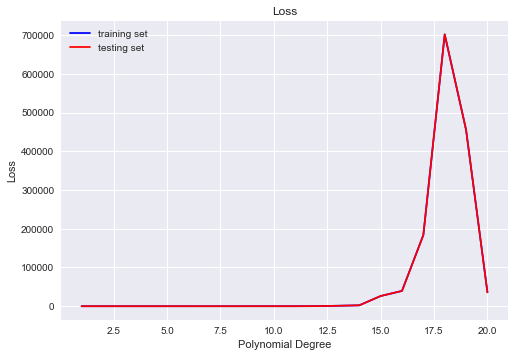

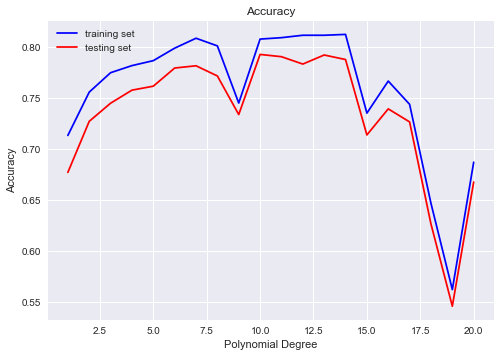

In [11]:
degrees = range(1,21)
rmse_tr = np.zeros(len(degrees))
rmse_ts = np.zeros(len(degrees))
pred_tr = np.zeros(len(degrees))
pred_ts = np.zeros(len(degrees))


for ind, degree in enumerate(degrees):
    #train the model
    X_test_poly = build_poly(X_test,degree)
    X_train_poly = build_poly(X_train,degree)
    w = least_squares(y_train, X_train_poly)
    rmse_tr[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_tr[ind] = pred_accuracy(predict_labels(w,X_train_poly),y_train)
    
    #test the model
    
    rmse_ts[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_ts[ind] = (pred_accuracy(predict_labels(w, X_test_poly),y_test))
    
    # print the update
    print("degree: {d} \t rmse_ts: {a} \t  pred_ts: {b}".format(d = degree, a = rmse_ts[ind], b = pred_ts[ind]))


    

# plot the loss
plt.style.use('seaborn')
plt.plot(degrees,rmse_tr, c='blue')
plt.plot(degrees,rmse_ts, c='red')
plt.title('Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


#plot the accuracy
plt.style.use('seaborn')
plt.plot(degrees,pred_tr, c='blue')
plt.plot(degrees,pred_ts, c='red')
plt.title('Accuracy')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


Linear regression using ridge regression
===

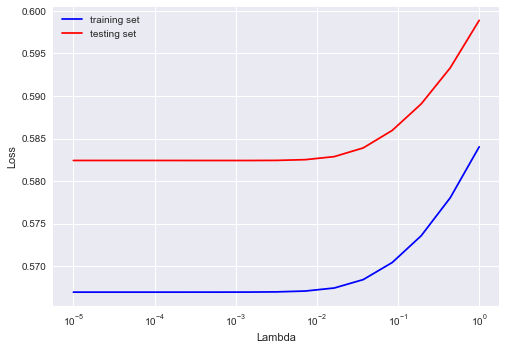

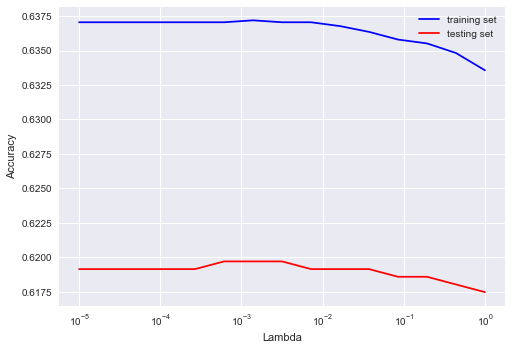

In [12]:
lambdas = np.logspace(-5, 0, 15)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train),y_train))
    
    
    rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test),y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse_tr, c='blue')
plt.semilogx(lambdas,rmse_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

# print(np.max(pred))

# Logistic regression

/Users/halimaschede/Documents/GitHub/machine_learning/project_1/implementations.py:18: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))
/Users/halimaschede/Documents/GitHub/machine_learning/project_1/implementations.py:18: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))


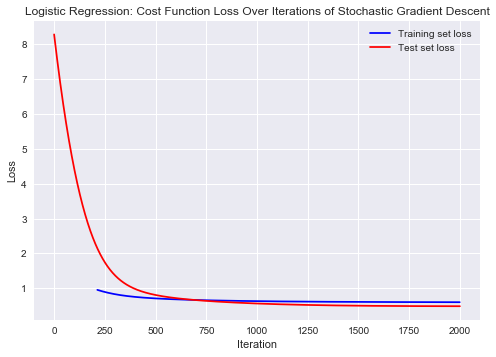

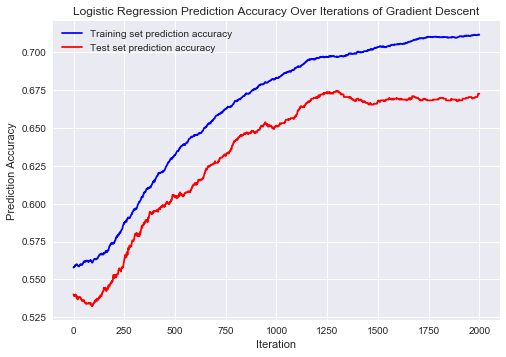

In [14]:
initial_w = np.random.rand(X_train.shape[1])
losses, ws = logistic_regression(y_train, X_train, initial_w, method = 'gd', max_iters = 2000) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()

# Regularized Logistic Regression